In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import Linear, ModuleList, ReLU
import torch.nn.functional as F
from torch.utils.data import Dataset

/home/dazhou/anaconda3/envs/calibration/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super().__init__()
        self.layers = ModuleList()
        input_fc = nn.Linear(input_dim, hidden_dim, bias=False)
        output_fc = nn.Linear(hidden_dim, output_dim, bias=False)
        self.layers.append(input_fc)
        if num_layers > 2:
            fc = nn.Linear(hidden_dim, hidden_dim, bias=False)
            self.layers.append(fc)
        self.layers.append(output_fc)
        self.num_layers = num_layers

    def forward(self, x):
        for i in range(self.num_layers-1):
            layer = self.layers[i]
            x = layer(x)
            x = F.relu(x)
        layer = self.layers[-1]
        x = layer(x)
        return x

In [3]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super().__init__()
        self.layers = ModuleList()
        rnn = torch.nn.GRU(input_dim,hidden_dim,num_layers)
        output_fc = nn.Linear(hidden_dim, output_dim, bias=False)
        self.layers.append(rnn)
        self.layers.append(output_fc)
        self.num_modules = 2

    def forward(self, x):
        for i in range(self.num_modules-1):
            layer = self.layers[i]
            x = layer(x)
            if type(x) is tuple:
                x=x[0][-1]
            x = F.relu(x)
        layer = self.layers[-1]
        x = layer(x)
        return x    

In [4]:
class myDataset(Dataset):
    def __init__(self, data):
        # with open(os.path.join(data_dir,file+"_ri.npy"), 'rb') as f:
        #     data = np.load(f)
        self.dataS=data[0]
        self.dataT=data[1] 
    def __len__(self) -> int:   #可以sample的数量
        return self.dataS.shape[0]
    def __getitem__(self, index):   #iNdex global
        return self.dataS[index],self.dataT[index]

In [5]:
class OneClassModel(nn.Module):
    def __init__(self, input_dim,input_dim_SRNN,input_dim_TRNN, hidden_dim, output_dim, num_layers=2, r=.1):
        super().__init__()
        self.encoder = MLP(input_dim, hidden_dim, output_dim, num_layers)
        self.Sencoder = RNN(input_dim_SRNN, hidden_dim, int(output_dim/2), num_layers)
        self.Tencoder = RNN(input_dim_TRNN, hidden_dim, int(output_dim/2), num_layers)
        self.center = torch.ones(output_dim, dtype=torch.float)
        self.r = torch.nn.Parameter(data=torch.tensor(r,dtype=torch.float), requires_grad=True)
    def forward(self, x):
        return self.encoder(x)
    def forward_RNN(self,x_s,x_t):
        embeds_s = self.Sencoder(x_s)
        embeds_t = self.Tencoder(x_t)
        embeds=torch.cat([embeds_s,embeds_t],1)
        return embeds
    
    def score(self, x):
        embeds = self.encoder(x)
        score = torch.cdist(embeds, self.center.view(1,-1))
        return score
    def score_RNN(self, x_s,x_t):
        embeds_s = self.Sencoder(x_s)
        embeds_t = self.Tencoder(x_t)
        embeds=torch.cat([embeds_s,embeds_t],1)
        score = torch.cdist(embeds, self.center.view(1,-1))
        return score    
    def oneclassLoss(self, x):
        embeds = self.encoder(x)
        distances = torch.cdist(embeds, self.center.view(1,-1))
        return torch.mean(torch.maximum(distances - self.r, torch.tensor([0.])))
    def oneclassLoss_RNN(self, x_s,x_t):
        embeds_s = self.Sencoder(x_s)
        embeds_t = self.Tencoder(x_t)
        embeds=torch.cat([embeds_s,embeds_t],1)
        distances = torch.cdist(embeds, self.center.view(1,-1))
        return torch.mean(torch.maximum(distances - self.r, torch.tensor([0.])))
data = torch.tensor(np.load("train.npy"), dtype=torch.float)
data_T=torch.rand(data.shape)
model = OneClassModel(input_dim=51*2,input_dim_SRNN=2,input_dim_TRNN=2, hidden_dim=16, output_dim=4, num_layers=3)

In [9]:
data.shape

torch.Size([9506, 4320, 2])

In [10]:
ds=myDataset([data,data_T])
dl=torch.utils.data.DataLoader(ds,batch_size=64, shuffle=True) 

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
model.train()
# for epoch in range(500):
#     loss = model.oneclassLoss(data.view(-1,51*2)) + model.r**2
#     # loss = model.oneclassLoss_RNN(data.permute(1,0,2),data_T.permute(1,0,2)) + model.r**2
#     print("Epoch:{:03d}, loss={:.4f}, r={:.4f}".format(epoch, float(loss), float(model.r)))
#     loss.backward()  # Derive gradients.
#     optimizer.step()  # Update parameters based on gradients.
#     optimizer.zero_grad()  # Clear gradients.
for epoch in range(500):
    loss_total=0
    for i,(data_s,data_t) in enumerate(dl):
        data_s, data_t = data_s.permute(1,0,2),data_t.permute(1,0,2) #length batch size
        # loss = model.oneclassLoss(data.view(-1,51*2)) + model.r**2
        loss = model.oneclassLoss_RNN(data_s,data_t) + model.r**2
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        loss_total+=loss.detach()
    print("Epoch:{:03d}, loss={:.4f}, r={:.4f}".format(epoch, float(loss_total), float(model.r)))

Epoch:000, loss=11.3047, r=0.0925
Epoch:001, loss=0.4504, r=0.0694
Epoch:002, loss=0.3907, r=0.0660
Epoch:003, loss=0.3699, r=0.0626
Epoch:004, loss=0.4565, r=0.1008
Epoch:005, loss=0.4507, r=0.0680
Epoch:006, loss=0.3837, r=0.0641
Epoch:007, loss=0.3781, r=0.0651
Epoch:008, loss=0.3741, r=0.0667
Epoch:009, loss=0.3754, r=0.0649
Epoch:010, loss=0.3578, r=0.0658
Epoch:011, loss=0.3933, r=0.0666
Epoch:012, loss=0.3692, r=0.0643
Epoch:013, loss=0.3717, r=0.0669
Epoch:014, loss=0.3911, r=0.0675
Epoch:015, loss=0.4036, r=0.0673
Epoch:016, loss=0.3808, r=0.0643
Epoch:017, loss=0.3596, r=0.0642
Epoch:018, loss=0.3823, r=0.0700
Epoch:019, loss=0.3556, r=0.0653
Epoch:020, loss=0.3429, r=0.0674
Epoch:021, loss=0.3680, r=0.0702
Epoch:022, loss=0.3705, r=0.0672
Epoch:023, loss=0.3470, r=0.0669
Epoch:024, loss=0.3609, r=0.0635
Epoch:025, loss=0.3611, r=0.0643
Epoch:026, loss=0.3602, r=0.0685
Epoch:027, loss=0.3802, r=0.0636
Epoch:028, loss=0.3693, r=0.0709
Epoch:029, loss=0.3603, r=0.0617
Epoch:030

In [8]:
torch.save(model,"model.pt")

In [10]:
embeds = model(data.view(-1,51*2))
distances = torch.cdist(embeds, model.center.view(1,-1))
scores = distances#torch.maximum(distances - .1, torch.tensor([0.]))

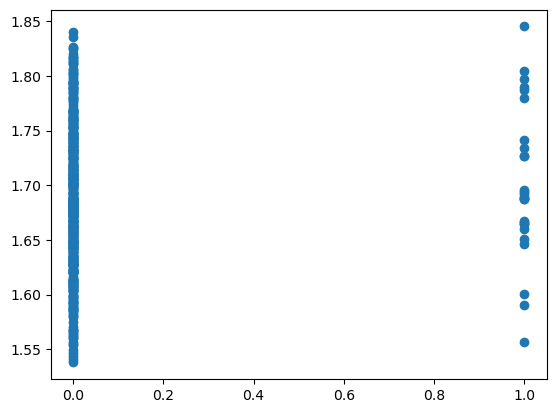

In [11]:
# plt.scatter(y_list, scores.view(-1).detach().numpy())
plt.scatter(y_list, model.score(data.view(-1,51*2)).view(-1).detach().numpy())

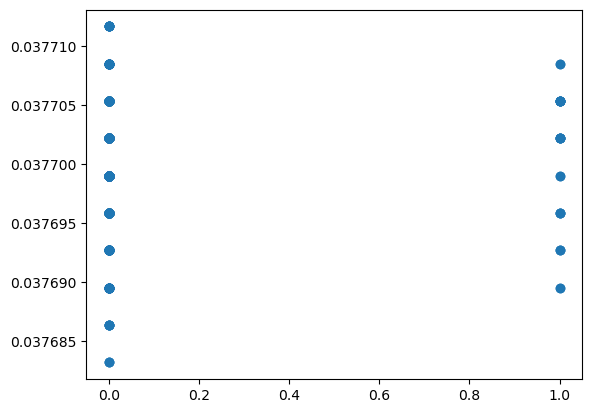

In [12]:
plt.scatter(y_list, model.score_RNN(data.permute(1,0,2),data_T.permute(1,0,2)).view(-1).detach().numpy())

In [13]:
sum(y_list)

27

In [14]:
len(y_list)

500